<a href="https://colab.research.google.com/github/bartheart/-CSCE_3100-Stack_implementation/blob/main/lego_detector_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import seaborn as sns
import tensorflow as tf
#from fastai.vision.all import *
#from fastai.vision.widgets import *
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/archive/dataset

Mounted at /content/drive
/content/drive/My Drive/archive/dataset


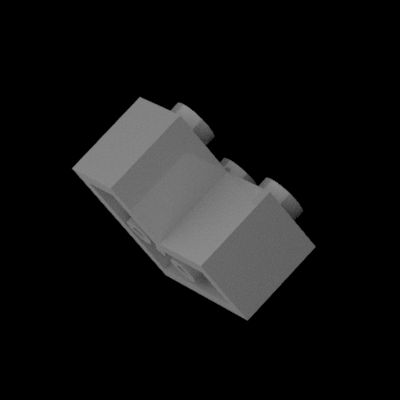

In [4]:
dir_ = Path("/content/drive/My Drive/archive/dataset")
path = "2357 brick corner 1x2x2 019R.png"
brick_image = Image.open(path)
brick_image.resize((200, 200))
brick_image

In [5]:
file_paths = list(dir_.glob(r'**/*.png'))
file_paths = [str(x) for x in file_paths]
df = pd.DataFrame({'Filepath':file_paths})

In [6]:
def get_label(string):
    string = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[1:-1])
    string = string.lower()
    return string

In [8]:
df['Label'] = df['Filepath'].apply(lambda x: get_label(x))
df

,Filepath,Label
0,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2
1,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m
2,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2
3,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2
4,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m
...,...,...
40207,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2
40208,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2
40209,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2
40210,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2


IndexError: index 24 is out of bounds for axis 0 with size 24

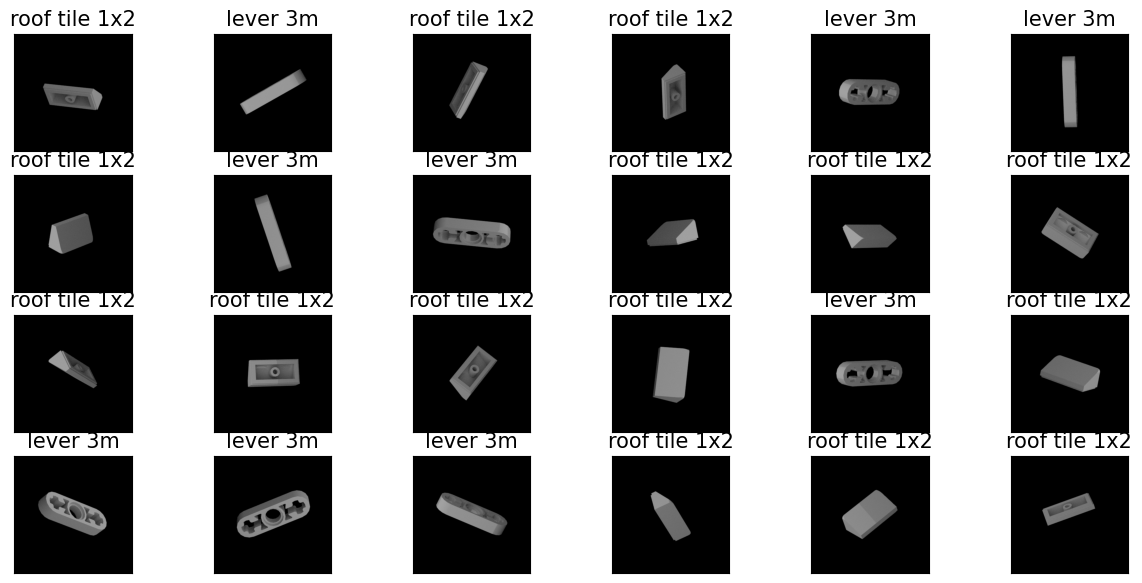

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, row in df.iterrows():
    filepath = row['Filepath']
    if os.path.isfile(filepath):
        ax = axes.flat[i]  # Access the corresponding subplot using index
        ax.imshow(plt.imread(filepath))
        ax.set_title(row['Label'], fontsize=15)
    else:
        ax.text(0.5, 0.5, "Error: File not found", ha='center', va='center', fontsize=12, color='red')

plt.tight_layout(pad=0.5)
plt.show()

<ipython-input-10-5c8b283eabc9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")


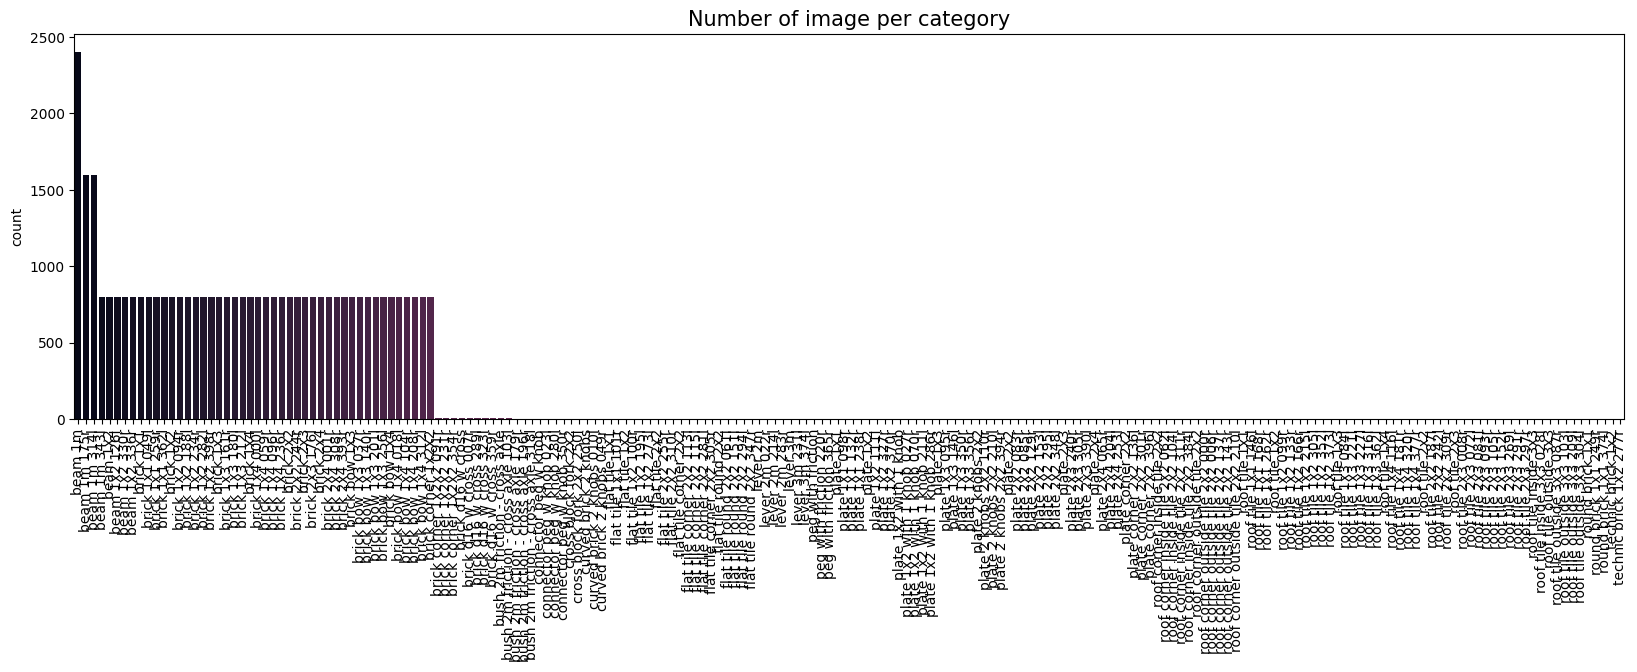

In [10]:
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of image per category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [12]:
validation = pd.read_csv('/content/drive/My Drive/archive/validation.txt', names = ['Filepath'])
validation['Filepath'] = validation['Filepath'].apply(lambda x: '/content/drive/My Drive/archive/dataset/' + x)
validation.head()

,Filepath
0,/content/drive/My Drive/archive/dataset/14719 ...
1,/content/drive/My Drive/archive/dataset/14719 ...
2,/content/drive/My Drive/archive/dataset/14719 ...
3,/content/drive/My Drive/archive/dataset/14719 ...
4,/content/drive/My Drive/archive/dataset/14719 ...


In [13]:
df['validation_set'] = df['Filepath'].isin(validation['Filepath'])
df

,Filepath,Label,validation_set
0,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2,False
1,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m,False
2,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2,False
3,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2,True
4,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m,False
...,...,...,...
40207,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False
40208,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False
40209,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False
40210,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False


In [14]:
train_df = df[df['validation_set'] == False].sample(frac = 0.3)
test_df = df[df['validation_set'] == True].sample(frac = 0.3)

In [15]:
print(f'Number of training images: {train_df.shape[0]}')
print(f'Number of testing images: {test_df.shape[0]}')

Number of training images: 9664
Number of testing images: 2400


In [16]:
def create_gen():
    # Charge les images avec un générateur et une augmentation de données
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [27]:
def get_model(model):
# Charge le modèle pré-entraîné
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(110, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [28]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [29]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 8698 validated image filenames belonging to 110 classes.
Found 966 validated image filenames belonging to 110 classes.
Found 2400 validated image filenames belonging to 46 classes.




In [30]:
# Define the chosen model
chosen_model_name = "DenseNet169"

# Get the model directly from the dictionary
model = get_model(models[chosen_model_name]["model"]) # Call the model function to create an instance
models[chosen_model_name]['model'] = model

start = perf_counter()

# Train the model directly (assuming you have defined the training logic)
history = model.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

# duration time
duration = perf_counter() - start
duration = round(duration,2)
print(f"Model trained in {duration} sec")

#model accuracy
val_acc = history.history['val_accuracy']
print(f"Model accuracy {val_acc}")

272/272 [==============================] - 3575s 13s/step - loss: 2.0755 - accuracy: 0.4223 - val_loss: 1.3295 - val_accuracy: 0.5942
Model trained in 3575.48 sec
Model accuracy [0.5942028760910034]


In [ ]:
model_save_path = '/content/drive/My Drive/archive'
model.save(model_save_path)

print('Model saved to:', model_save_path)

In [ ]:
model_save_path = '/content/drive/My Drive/archive/model.h5'
loaded_model = tf.keras.models.load_model(model_save_path)

In [ ]:
optimizer = 'adam'
loss_function = 'categorical_crossentropy'  # Adjust based on your training configuration

# Compile the loaded model
loaded_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [31]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Rapproche les labels
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Récupère l'accurary sur le test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

75/75 [==============================] - 1042s 14s/step


NameError: name 'best_model' is not defined

In [32]:
import matplotlib.pyplot as plt

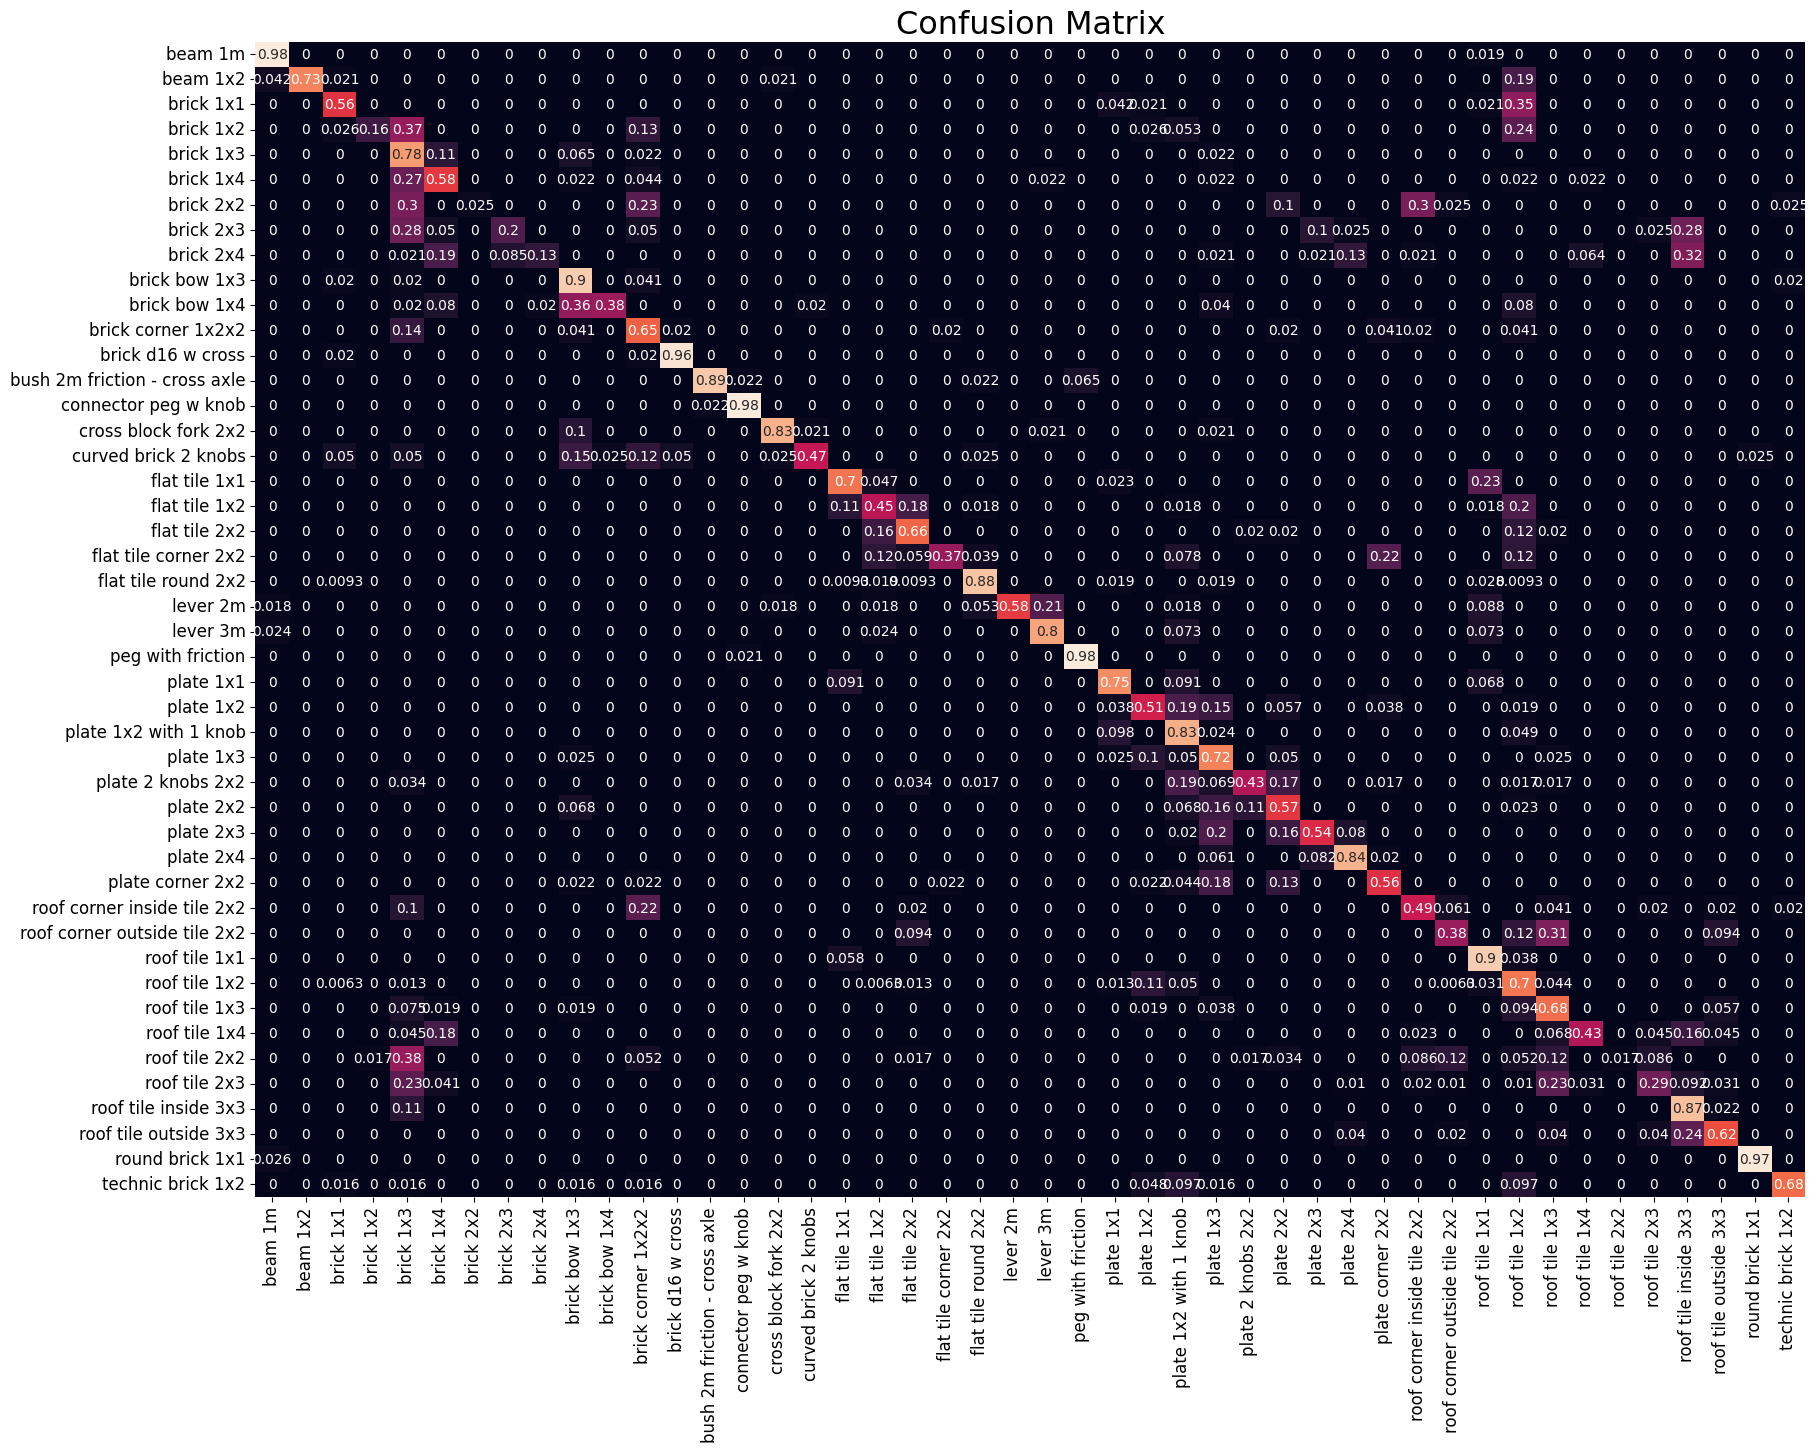

In [33]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12)
plt.show()

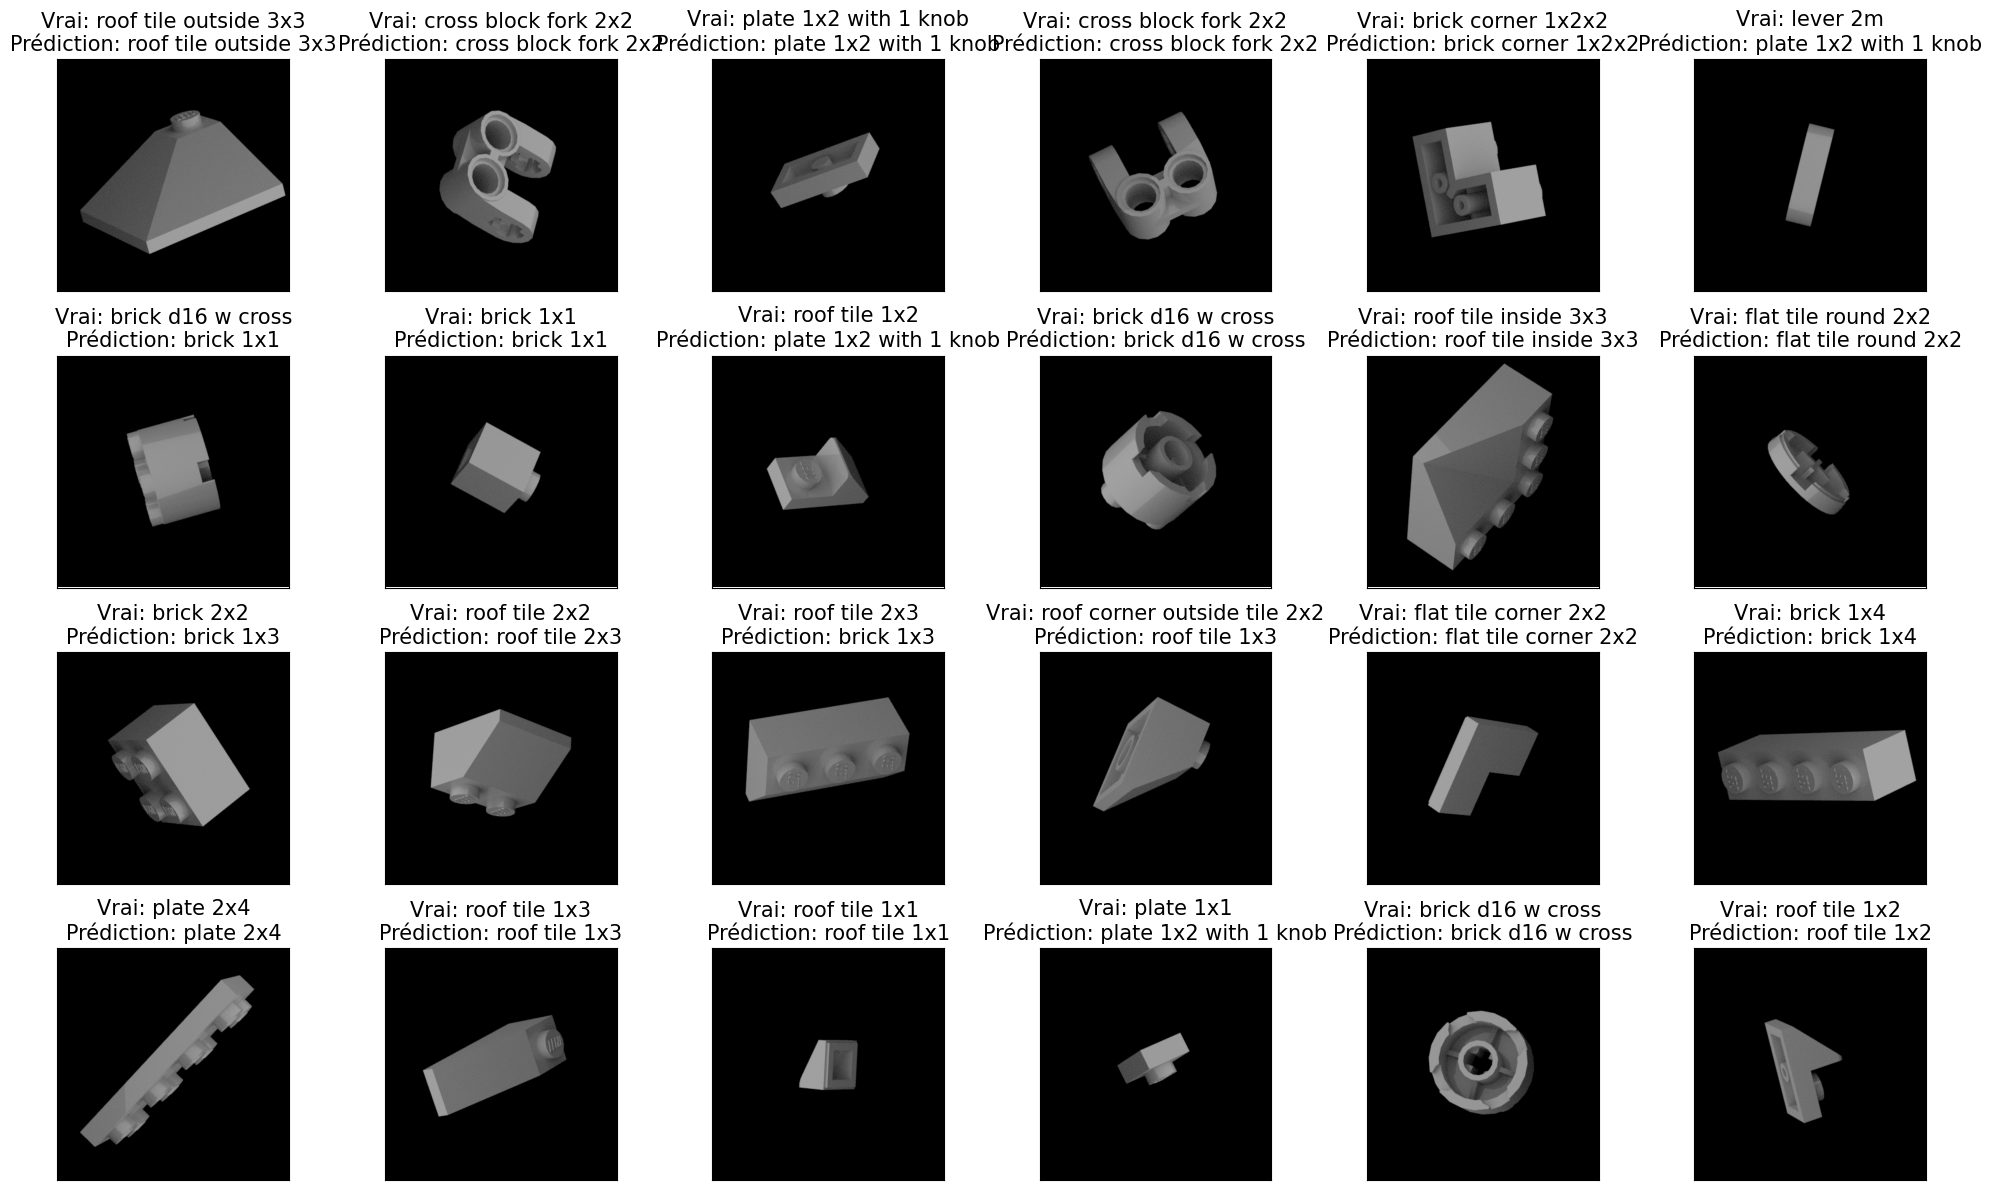

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"Vrai: {test_df.Label.iloc[i].split('_')[0]}\nPrédiction: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [35]:
model_save_path = '/content/drive/My Drive/archive/predictLego.h5'
model.save(model_save_path)

print('Model saved to:', model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /content/drive/My Drive/archive/predictLego.h5


In [38]:
image_path = "/content/drive/My Drive/archive/test_images/filled_image.jpg"

In [42]:
try:
  # Load the image
  img = Image.open(image_path)

  # Handle potential grayscale conversion if needed
  if img.mode != 'RGB':
      img = img.convert('RGB')

  # Resize the image to match your model's input size
  img = img.resize((224, 224))

  # Convert to a NumPy array
  img_array = np.array(img)

  # Print the shape for verification (should be (224, 224, 3))
  print(img_array.shape)

  # Assuming your model preprocesses for 'imagenet'
  img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array.reshape((1, 224, 224, 3)))

except Exception as e:
  print(f"Error loading image: {e}")

(224, 224, 3)


In [43]:
prediction = model.predict(img_array)

# Get the index of the predicted class with the highest probability
predicted_class = np.argmax(prediction)

# Get the class label from your training data (assuming labels are encoded)
labels = (train_images.class_indices)  # Assuming you have labels stored here
labels = dict((v, k) for k, v in labels.items())
predicted_label = labels[predicted_class]

print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 3s 3s/step
Predicted Label: roof tile inside 3x3


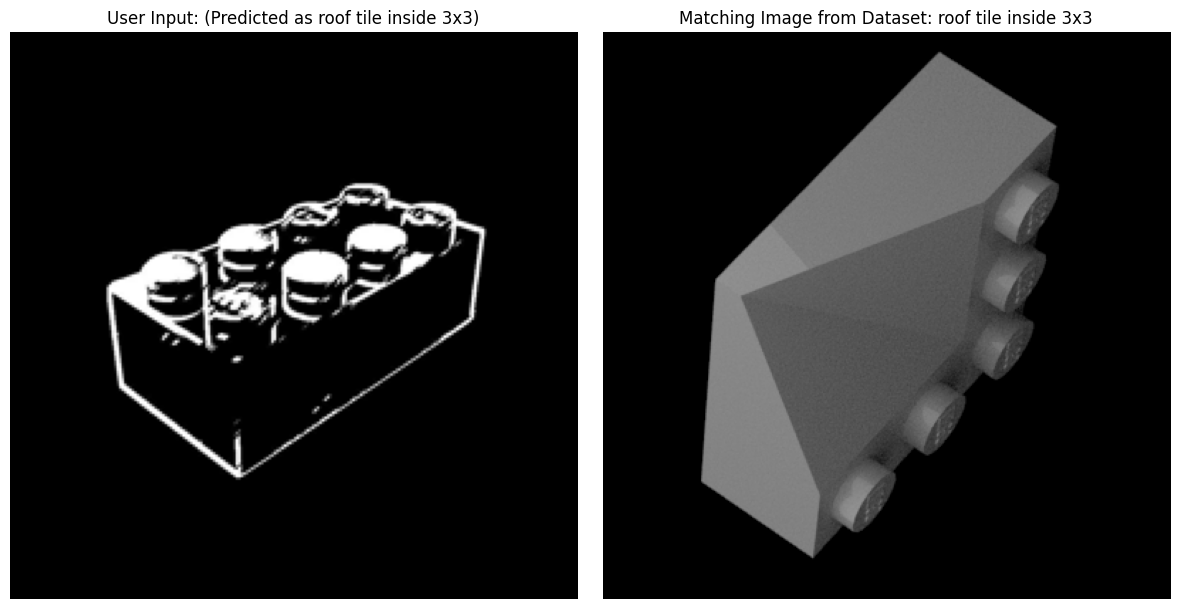

In [49]:
matching_image = None
for index, row in test_df.iterrows():
  if row['Label'] == predicted_label:
    matching_image_path = row['Filepath']
    matching_image = Image.open(matching_image_path)
    break

if matching_image is None:
  print(f"No image found in the dataset for predicted label: {predicted_label}")
else:
  # Display the user input image and matching image (without unnecessary preprocessing)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  ax1.imshow(img)
  ax1.set_title(f"User Input: (Predicted as {predicted_label})")
  ax1.axis('off')

  ax2.imshow(matching_image)
  ax2.set_title(f"Matching Image from Dataset: {predicted_label}")
  ax2.axis('off')

  plt.tight_layout()
  plt.show()